In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

from glob import glob
import random

5000
/common/users/dm1487/inhand_manipulation_data_store/datastore_44/9/2023-10-31_20-37-05.npz
147


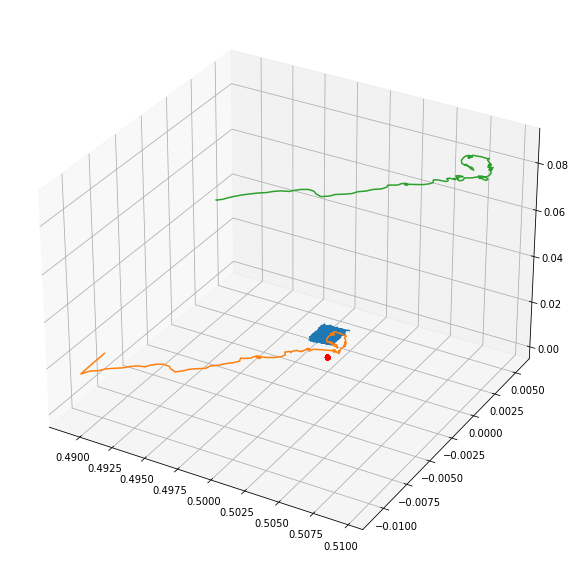

In [16]:
all_paths = glob('/common/users/dm1487/inhand_manipulation_data_store/datastore_44/*/*.npz')
print(len(all_paths))
path = random.sample(all_paths, 1)[0]
data = np.load(path)
# path = random.sample(all_paths, 1)[0]
print(path)
done_idx = data['done'].nonzero()[-1][0]
print(done_idx)
ax = plt.figure(figsize=(10, 20)).add_subplot(projection='3d')
ax.scatter(data['socket_pos'][:done_idx, 0], data['socket_pos'][:done_idx, 1], zs=data['socket_pos'][:done_idx, 2], color='r')
ax.plot(data['noisy_socket_pos'][:done_idx, 0], data['noisy_socket_pos'][:done_idx, 1], zs=data['noisy_socket_pos'][:done_idx, 2])
ax.plot(data['plug_pos'][:done_idx, 0], data['plug_pos'][:done_idx, 1], zs=data['plug_pos'][:done_idx, 2])
ax.plot(data['eef_pos'][:done_idx, 0], data['eef_pos'][:done_idx, 1], zs=data['eef_pos'][:done_idx, 2])

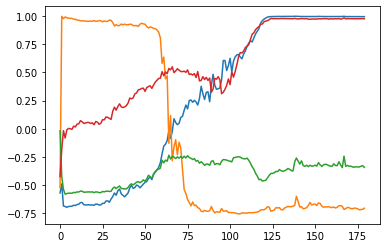

In [3]:
latent = data['latent']
plt.plot(latent[:done_idx, :])

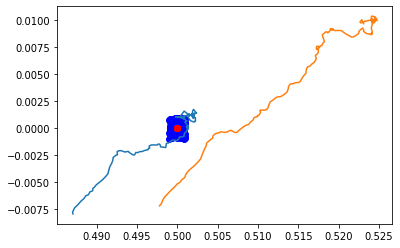

In [4]:
plt.scatter(data['noisy_socket_pos'][1:done_idx, 0], data['noisy_socket_pos'][1:done_idx, 1], color='b')
plt.plot(data['plug_pos'][1:done_idx, 0], data['plug_pos'][1:done_idx, 1])
plt.plot(data['eef_pos'][1:done_idx, 0], data['eef_pos'][1:done_idx, 1])
plt.scatter(data['socket_pos'][1:done_idx, 0], data['socket_pos'][1:done_idx, 1], color='r', s=35)

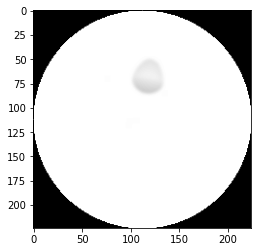

In [5]:
plt.imshow(data['tactile'][50][2][:], cmap='gray')

In [152]:
# np.mean(data['tactile'][:][0], axis=-1).shape


0.093949325 0.19505441
0.09396408 0.19507743
0.09386859 0.19489673


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
video = cv2.VideoWriter('video.avi', fourcc, 20, (672, 224), isColor=False)


for j in tqdm(range(0,done_idx)):
    tactile_img = data['tactile']
    img1 = tactile_img[j][0]
    img2 = tactile_img[j][1]
    img3 = tactile_img[j][2]
    img = np.concatenate([img1, img2, img3], axis=1)
    video.write((img*255).astype(np.uint8))
cv2.destroyAllWindows()
video.release()

# video2 = cv2.VideoWriter('video2.avi', fourcc, 20, (224, 224), isColor=False)
# for j in tqdm(range(0,done_idx)):
#   img2 = data['tactile'][j][1]
#   video2.write((img2*255).astype(np.uint8))
# cv2.destroyAllWindows()
# video2.release()

# video3 = cv2.VideoWriter('video3.avi', fourcc, 20, (224, 224), isColor=False)
# for j in tqdm(range(0,done_idx)):
#   img3 = data['tactile'][j][2]
#   video3.write((img3*255).astype(np.uint8))
# cv2.destroyAllWindows()
# video3.release()

In [83]:
data['latent'].max()

0.9950234

In [33]:
from tqdm import tqdm
import os
maxs, mins, means = [], [], []
means1, means2, means3 = [], [], []
for i in tqdm(random.sample(all_paths, 2000)):
    dat = np.load(i)
    done_idx = dat['done'].nonzero()[-1][0]
    if done_idx == 0:
        print(i)
        os.remove(i)
        continue
    # arm_joints = dat["arm_joints"]
    # eef_pos = dat["eef_pos"]
    # noisy_socket_pos = dat["noisy_socket_pos"][..., :3]
    arg = dat["target"]
    # target = dat["target"]
    # latent = dat["latent"]
    
    
    # action = (dat['action'] - np.array([ 0.2201746 ,  0.14593899, -0.31790477, -0.08718379, -0.38278046,
    #     -0.16994749])) /np.array([0.26710942, 0.21309814, 0.11707424, 0.11714543, 0.1739292 ,
    #     0.1880126 ])

    # target = (dat['target'] - np.array([ 0.19636554,  0.09685931, -0.13117813, -0.01892477, -0.0438366 ,
    #     -0.01055622])) /np.array([0.1473922 , 0.12038091, 0.12884894, 0.01951226, 0.02881789,
    #     0.02477906])

    # arm_joints = (dat['arm_joints'] - np.array([ 0.01614119,  0.42856988, -0.00953079, -1.7774932 ,  0.00362174,
    #      0.9268473 , -1.5648024 ])) /np.array([0.00953417, 0.01540671, 0.00851188, 0.02405739, 0.0055609 ,
    #     0.02908119, 0.01539389])

    # eef_pos = (dat['eef_pos'] - np.array([ 5.1020551e-01,  3.7322051e-03,  8.3922528e-02, -8.9522096e-04,
    #     -9.9945158e-01,  9.1888672e-03, -9.9991244e-01,  9.8818389e-04,
    #     -1.2169459e-03,  1.4181134e-03, -9.2603108e-03, -9.9950248e-01])) /np.array([0.00551711, 0.00485224, 0.00253855, 0.00927832, 0.00150553,
    #     0.0207699 , 0.00025508, 0.00899514, 0.00537677, 0.00483323,
    #     0.02086152, 0.00138193])

    # noisy_socket_pos = (noisy_socket_pos - np.array([ 4.9999946e-01,  3.8727401e-07])) /np.array([4.2466829e-05, 4.3809032e-05])

    
    
    means.append(arg[:done_idx].mean(axis=0))

    # means1.append(np.mean(data['tactile'][:, 0, ...]))
    # means2.append(np.mean(data['tactile'][:, 1, ...]))
    # means3.append(np.mean(data['tactile'][:, 2, ...]))
    
    # print(, np.std(data['tactile'][:, 0, ...]))
    # print(np.mean(data['tactile'][:, 1, ...]), np.std(data['tactile'][:, 1, ...]))
    # print(np.mean(data['tactile'][:, 2, ...]), np.std(data['tactile'][:, 2, ...]))

    
    # mins.append(dat['action'][:done_idx].min(axis=-1))
    # maxs.append(dat['action'][:done_idx].max(axis=-1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 686.46it/s]


In [35]:
np.array(means).mean(axis=0), np.array(means).std(axis=0)
# print(np.array(means2).mean(), np.array(means2).std())
# print(np.array(means3).mean(), np.array(means3).std())

(array([ 0.1890946 ,  0.09494171, -0.13034055, -0.017735  , -0.04408294,
        -0.01140882], dtype=float32),
 array([0.14689375, 0.1168748 , 0.13062255, 0.01941508, 0.02962011,
        0.02537596], dtype=float32))

(array([  19.,   53.,   50.,  102.,  154., 2322.,  142.,   27.,   58.,
          73.]),
 array([-0.34267113, -0.28447384, -0.22627656, -0.16807927, -0.10988199,
        -0.05168471,  0.00651258,  0.06470986,  0.12290715,  0.18110442,
         0.23930171]),
 <BarContainer object of 10 artists>)

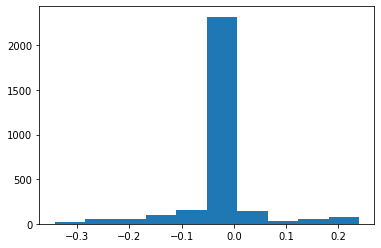

In [36]:
# (arg - np.array([ 0.22748329,  0.14347284, -0.31690967, -0.09126362, -0.3803397 ,
#         -0.16394056])) / np.array([0.26493645, 0.20685168, 0.11630305, 0.12485585, 0.1740476 ,
#         0.18915313])
plt.hist(arg.flatten())

In [87]:
np.array(means).mean(axis=0),  np.array(means).std(axis=0) # , np.array(mins).min(axis=0)

(array([-0.01527036, -0.01583448,  0.02519814,  0.02748504,  0.00434698,
        -0.0465755 ]),
 array([0.9685    , 0.98335612, 0.9577198 , 0.95297185, 0.97983495,
        0.99298225]))

In [146]:
np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3515406556.py:1: RuntimeWarning: Mean of empty slice.
  np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

In [184]:
np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3689302195.py:1: RuntimeWarning: Mean of empty slice.
  np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)


(nan, nan)

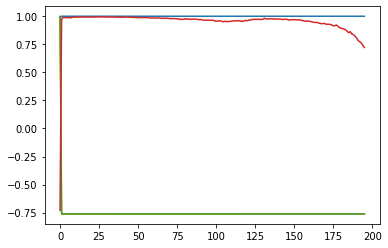

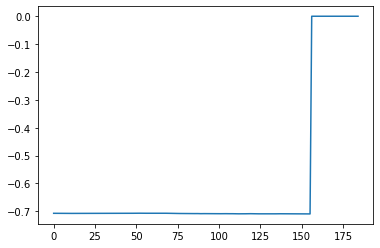

In [208]:
plt.plot(data['eef_pos'][:done_idx, 3])

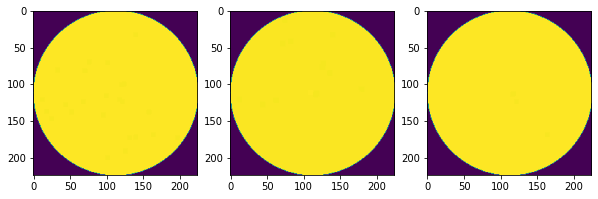

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(10, 30))
t = 0

# (dat['tactile'][t][0]).min()


ax[0].imshow(dat['tactile'][t][0])
ax[1].imshow(dat['tactile'][t][1])
ax[2].imshow(dat['tactile'][t][2])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [02:06<00:00,  2.31it/s]


In [239]:
def denormalize_image(image, min_value, max_value):
    denormalized_image = (image + 1) * 0.5 # * (max_value - min_value) + min_value
    return denormalized_image

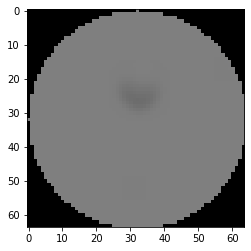

In [80]:
plt.imshow(denormalize_image(data['tactile_img'][0][150, 0], 0, 1))

In [1]:
import torch
import time

In [36]:
a = torch.randn(1250000, 1000)

In [43]:
st = time.time()
a = a.to('cuda:0')
time.time() - st

6.580352783203125e-05